# Explore product question data
Let's look at the questions asked about Amazon products and figure out how many questions could be avoided with better product information.

In [26]:
# load data
import json
from ast import literal_eval
import pandas as pd
question_data = list(map(lambda x: literal_eval(x.strip()), list(open('../../data/amazon_questions/QA_Beauty.json', 'r'))))
question_data = pd.DataFrame(question_data)
flat_question_data = []
id_var = 'asin'
for idx_i, row_i in question_data.iterrows():
    id_i = row_i.loc[id_var]
    for question_j in row_i.loc['questions']:
        row_j = pd.Series(question_j)
        row_j.loc[id_var] = id_i
        flat_question_data.append(row_j)
question_data = pd.DataFrame(flat_question_data)
# print(len(question_data))
question_data.drop_duplicates(['askerID', 'asin'], inplace=True)
display(question_data.head())

,questionType,askerID,questionTime,questionText,answers,asin
0,open-ended,A3VTSR929E3J0R,"December 26, 2013",May I request for a manual instruction on this...,[{'answerText': 'Homedics has a complete list ...,B000050FES
1,open-ended,A1LZ5DJ7AJYAXD,"April 26, 2014",Having problems with the heater melting the wa...,[{'answerText': 'I leave the unit on all the t...,B000050FES
2,yes/no,A1ER8W5FAQM6G5,"July 11, 2014","How much wax (in pounds, for instance) does it...",[{'answerText': 'It came with the proper amoun...,B000050FES
3,open-ended,A1P403R4I7LVPU,"December 20, 2013",How to know the expired date of this product?,[{'answerText': 'The expiration date is on the...,B000052YQ2
4,open-ended,A166KM8A5H1Z2O,"February 26, 2014",I am not in the sun as I work inside. I am new...,[{'answerText': 'This product is awesome. I do...,B000052YQ2


In [56]:
# load original Amazon data lol
import pandas as pd
from ast import literal_eval
product_data = pd.read_csv('../../data/amazon_questions/beauties_meta.csv', sep=',', usecols=['title', 'description', 'asin'])
# cleanup
product_data.drop_duplicates('asin', inplace=True)
product_data = product_data[product_data.loc[:, 'description'].apply(lambda x: type(x) is str)]
MAX_TITLE_LEN=300
product_data = product_data[product_data.loc[:, 'title'].apply(lambda x: len(x) <= MAX_TITLE_LEN)]
product_data = product_data.assign(**{
    'description' : product_data.loc[:, 'description'].apply(lambda x: ' '.join(literal_eval(x)))
})
print(product_data.shape[0])

26435


In [58]:
# join
id_var = 'asin'
question_product_data = pd.merge(question_data, product_data, on=id_var, how='inner')
print(question_product_data.shape[0])
display(question_product_data.head())

1427


,questionType,askerID,questionTime,questionText,answers,asin,title,description
0,open-ended,A3N6N65DTY9ZGT,"April 21, 2014","Does this come with a Nozelle, It is not seen ...",[{'answerText': 'It does but I received mine o...,B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Purity. Unity. Fresh. The revolutionary first ...
1,open-ended,A135JOCMPYCUSD,"December 20, 2014",for men and women?,"[{'answerText': 'Yes!', 'answererID': 'ACG8MGW...",B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Purity. Unity. Fresh. The revolutionary first ...
2,open-ended,A2U82KFX9GIGOL,"November 19, 2013",6.8,[{'answerText': 'I don't know what the questio...,B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Purity. Unity. Fresh. The revolutionary first ...
3,open-ended,A2Y0UTFYSEMZ8I,"February 7, 2014",Where the product was made?,"[{'answerText': 'USA', 'answererID': 'A6VJFRHO...",B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Purity. Unity. Fresh. The revolutionary first ...
4,open-ended,A10FUL5K3YMYA3,"December 6, 2014",Has anyone noticed the increase in the price f...,[{'answerText': 'I don't get that either. I al...,B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Purity. Unity. Fresh. The revolutionary first ...


### Sample questions, determine answer-ability
How many of the questions in the reviews could have been avoided by changing the product description?

In [59]:
import numpy as np
np.random.seed(123)
sample_size = 100
sample_question_product_id = np.random.choice(question_product_data.loc[:, id_var].unique(), sample_size, replace=False)
sample_question_product_data = question_product_data[question_product_data.loc[:, id_var].isin(sample_question_product_id)].drop_duplicates(id_var, inplace=False)
sample_question_product_data = sample_question_product_data.assign(**{'idx' : np.arange(1,sample_size+1)})
print(len(sample_question_product_id))
print(sample_question_product_data.shape[0])

100
100


In [60]:
def print_question_data(data):
    print('%d: product=<%s> description=<%s> question=<%s>'%(data.loc['idx'], data.loc['title'], data.loc['description'], data.loc['questionText']))
sample_question_product_data.apply(print_question_data, axis=1)

1: product=<NOW Red Clay Powder Moroccan, 6-Ounce> description=<100% Pure Facial Detox/Sensitive Skin Types Condition: Sensitive Skin in need of detoxification to remove impurities and in need of a smaller pore size and tighter skin tone. Solution: Moroccan Red Clay is an all-natural powder clay that is highly absorbent and mixes easily with water and other moisturizing products. It serves as an excellent facial cleanser and purifying masque, especially for individuals with sensitive skin.> question=<is this rhassoul clay?>
2: product=<Tea Tree Special Shampoo 1 Gallon without pump> description=<A special combination of cleansers and Australian tea tree oil leave hair refreshingly clean, while enhancing vitality and adding lusterrnStimulates - The combination of tea tree oil and peppermint create a cooling tinglernInvigorates - The unique combination of tea tree oil, peppermint, and lavender createsrna refreshing fragrance experience.> question=<Just bought a paul mitchell tea tree sha

33      None
61      None
72      None
79      None
92      None
        ... 
1347    None
1351    None
1368    None
1403    None
1409    None
Length: 100, dtype: object

Labels: 1=question could have been answered with more information in description, 0 otherwise

1
1
1
1
0
0
0
0
1
1
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
0
0
1
0
0
0
0
1
0
0
1
1
1
0
0
1
0
0
1
1
0
1
1
0
0
1
1
1
0
1
0
1
1
1
0
1
1
0
0
1
1
0
1
0
1
1
1
0
1
0
0
0
1
0
1
1
0
1
1
0
1
0
0
0
1
1
1
1
0
1
0
1
1
1
0

In [61]:
sample_question_product_data_labels = [1,1,1,1,0,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,1,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,0,0,1,0,1,1,0,1,1,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,0]
print('%d/%d questions could have been answered with better description information'%(sum(sample_question_product_data_labels), len(sample_question_product_data_labels)))

55/100 questions could have been answered with better description information


This is pretty good! A writer might have a decent chance at preempting some of the readers' questions with better information organization.

### Check question overlap
How much overlap do these questions have with the text in the description? 

In [83]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def compute_mean_embedding(text_tokens, embeddings, vocab):
    # de-duplicate tokens
    text_tokens = list((filter(lambda x: x in vocab, text_tokens))
    text_embeddings = np.vstack(list(map(lambda x: embeddings.loc[x, :].values, text_tokens)))
    mean_embedding = text_embeddings.mean(axis=0)
    return mean_embedding
def compute_text_sim(text_1, text_2, embeddings, vocab):
    # compute text similarity based on 
    # distance between average word embeddings
    mean_embedding_1 = compute_mean_embedding(text_1, embeddings, vocab)
    mean_embedding_2 = compute_mean_embedding(text_2, embeddings, vocab)
    sim_1_2 = cosine_similarity(mean_embedding_1.reshape(1,-1), mean_embedding_2.reshape(1,-1))[0][0]
    return sim_1_2

In [80]:
## load embeddings lol
import numpy as np
import pandas as pd
embedding_file = '../../../product_recommendation/topic_modeling/src/Neural_Document_Modeling/data/review_data/glove.6B.300d.npy'
vocab_file = '../../../product_recommendation/topic_modeling/src/Neural_Document_Modeling/data/review_data/vocab'
embeddings = np.load(embedding_file)
vocab = [l.strip().split(' ')[0] for l in open(vocab_file, 'r')] # assume that vocab is sorted
vocab_set = set(vocab)
# remove stopwords from vocab for more accurate embeddings?
from stop_words import get_stop_words
en_stops = set(get_stop_words('en'))
vocab_set = vocab_set - en_stops
# vocab = dict(vocab)
# combine
embeddings = pd.DataFrame(embeddings, index=vocab)
display(embeddings.head())

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
<unk>,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.28836,0.21521,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.28506,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.17854,0.10756,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.56686,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.10721,0.23697,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.24618,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.17521,0.12137,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.47841,0.068617,0.183510,-0.291830,-0.046533


Let's compute the similarity between all sample text passages and the sample question.

In [96]:
sample_descriptions = sample_question_product_data.loc[:, 'description'].values
sample_questions = sample_question_product_data.loc[:, 'questionText'].values
# tokenize
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
sample_description_tokens = list(map(tokenizer.tokenize, sample_descriptions))
sample_question_tokens = list(map(tokenizer.tokenize, sample_questions))
sample_description_question_sim = np.array(list(map(lambda x: compute_text_sim(x[0], x[1], embeddings, vocab_set), 
                                                    zip(sample_description_tokens, sample_question_tokens))))

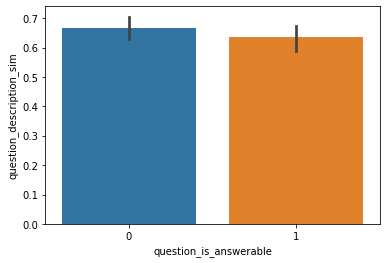

questions have difference in similarity = 0.042 (test stat = 1088.000, p = 1.510E-01)


In [99]:
# combine with labels
sample_description_question_sim_data = pd.DataFrame(sample_description_question_sim, columns=['question_description_sim'])
sample_description_question_sim_data = sample_description_question_sim_data.assign(**{
    'question_is_answerable' : sample_question_product_data_labels
})
# print(sample_description_question_sim_data.head())
## compare similarity for answerable and un-answerable questions
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x='question_is_answerable', y='question_description_sim', data=sample_description_question_sim_data)
plt.show()
## test for difference
non_answerable_sim = sample_description_question_sim_data[sample_description_question_sim_data.loc[:, 'question_is_answerable']==0].loc[:, 'question_description_sim']
answerable_sim = sample_description_question_sim_data[sample_description_question_sim_data.loc[:, 'question_is_answerable']==1].loc[:, 'question_description_sim']
median_sim_diff = non_answerable_sim.median() - answerable_sim.median()
from scipy.stats import mannwhitneyu
test_stat, p_val = mannwhitneyu(non_answerable_sim, answerable_sim)
print('questions have difference in similarity = %.3f (test stat = %.3f, p = %.3E)'%(median_sim_diff, test_stat, p_val))

Not what I expected! 

The un-answerable questions are slightly more similar to their descriptions than the answerable questions. Potentially because the un-answerable questions often call out the product by name while addressing aspects of the product that the writer couldn't answer, e.g. "is the shampoo authentic". This contrasts with answerable questions which call out aspects that are unmentioned, e.g. "how long is it?"